In [133]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, accuracy_score, precision_score, recall_score
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.metrics import roc_curve

from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import OneHotEncoder

import seaborn as sns

In [95]:
df = pd.read_json('ultimate_data_challenge.json')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 12 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   city                    50000 non-null  object 
 1   trips_in_first_30_days  50000 non-null  int64  
 2   signup_date             50000 non-null  object 
 3   avg_rating_of_driver    41878 non-null  float64
 4   avg_surge               50000 non-null  float64
 5   last_trip_date          50000 non-null  object 
 6   phone                   49604 non-null  object 
 7   surge_pct               50000 non-null  float64
 8   ultimate_black_user     50000 non-null  bool   
 9   weekday_pct             50000 non-null  float64
 10  avg_dist                50000 non-null  float64
 11  avg_rating_by_driver    49799 non-null  float64
dtypes: bool(1), float64(6), int64(1), object(4)
memory usage: 4.2+ MB


In [80]:
df.head()

,city,trips_in_first_30_days,signup_date,avg_rating_of_driver,avg_surge,last_trip_date,phone,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver
0,King's Landing,4,2014-01-25,4.7,1.10,2014-06-17,iPhone,15.4,True,46.2,3.67,5.0
1,Astapor,0,2014-01-29,5.0,1.00,2014-05-05,Android,0.0,False,50.0,8.26,5.0
2,Astapor,3,2014-01-06,4.3,1.00,2014-01-07,iPhone,0.0,False,100.0,0.77,5.0
3,King's Landing,9,2014-01-10,4.6,1.14,2014-06-29,iPhone,20.0,True,80.0,2.36,4.9
4,Winterfell,14,2014-01-27,4.4,1.19,2014-03-15,Android,11.8,False,82.4,3.13,4.9


1 clean - viz - what fraction of observed users were retained?

2 predictive model to help determine wither or not users will be active in 6 months

explain apporach alternatives and concerns, how valid is model? include ley model indicators 

In [81]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
trips_in_first_30_days,50000.0,2.278200,3.792684,0.0,0.00,1.00,3.00,125.00
avg_rating_of_driver,41878.0,4.601559,0.617338,1.0,4.30,4.90,5.00,5.00
avg_surge,50000.0,1.074764,0.222336,1.0,1.00,1.00,1.05,8.00
surge_pct,50000.0,8.849536,19.958811,0.0,0.00,0.00,8.60,100.00
weekday_pct,50000.0,60.926084,37.081503,0.0,33.30,66.70,100.00,100.00
avg_dist,50000.0,5.796827,5.707357,0.0,2.42,3.88,6.94,160.96
avg_rating_by_driver,49799.0,4.778158,0.446652,1.0,4.70,5.00,5.00,5.00


In [96]:
df.duplicated().sum()

8

In [97]:
df = df.drop_duplicates(keep='first')

## Create target column retained of riders who have used the service in the last 30 days


In [98]:
df.last_trip_date.max()

'2014-07-01'

In [99]:
# 30 days or more recent used to select retained
retained = df[df.last_trip_date>'2014-06-01']
# create new column 
df['retained'] = np.where(df['last_trip_date']>'2014-06-01',1,0)

df['retained'].value_counts()

0    31682
1    18310
Name: retained, dtype: int64

In [100]:
def calc_prevalence(y):
 return (sum(y)/len(y))
calc_prevalence(df.retained)

0.3662586013762202

## Clean up features with nulls and boolens for modeling 

In [101]:
print(df['avg_rating_of_driver'].mean())
df['avg_rating_of_driver'] = df['avg_rating_of_driver'].fillna(np.mean(df['avg_rating_of_driver']))
print(df['avg_rating_of_driver'].mean())

4.6015117139921236
4.601511713991798


In [102]:
df["avg_rating_by_driver"] = df["avg_rating_by_driver"].fillna(np.mean(df["avg_rating_by_driver"]))

In [103]:
# bias tells me use iPhone for nulls 

df['phone']=df['phone'].fillna('iPhone')

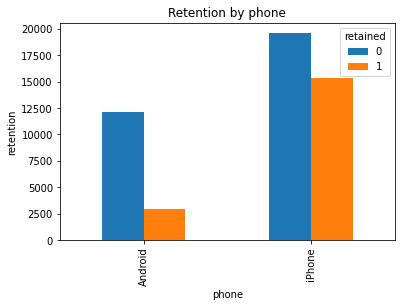

In [104]:
pd.crosstab(df.phone,df.retained).plot(kind='bar')
plt.title('Retention by phone')
plt.xlabel('phone')
plt.ylabel('retention')
plt.savefig('retention by phone')

## There is a clear difference in rate of retention between the different phone groups

In [105]:
df['phone'] = np.where(df['phone']=='iPhone',1,0)
df['phone'].value_counts()

1    34974
0    15018
Name: phone, dtype: int64

Text(0, 0.5, 'usage')

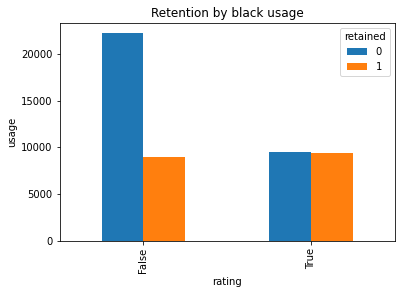

In [106]:
pd.crosstab(df.ultimate_black_user,df.retained).plot(kind='bar')
plt.title('Retention by black usage')
plt.xlabel('rating')
plt.ylabel('usage')
# plt.savefig('retention by rating by driver')

In [107]:
### Users of black are much more likely to be retained than ones that do not

In [108]:
df['ultimate_black_user']=np.where(df['ultimate_black_user'] ==True,1,0)

In [109]:
## create day of week from sign up date feature
df['signup_date'] =pd.to_datetime(df['signup_date'],format='%Y-%m-%d')
df['signup_date_dayofweek'] = df['signup_date'].dt.dayofweek


In [71]:
df.isna().sum()

city                      0
trips_in_first_30_days    0
signup_date               0
avg_rating_of_driver      0
avg_surge                 0
last_trip_date            0
phone                     0
surge_pct                 0
ultimate_black_user       0
weekday_pct               0
avg_dist                  0
avg_rating_by_driver      0
retained                  0
signup_date_dayofweek     0
singup_month              0
dtype: int64

In [72]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 49992 entries, 0 to 49999
Data columns (total 15 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   city                    49992 non-null  object        
 1   trips_in_first_30_days  49992 non-null  int64         
 2   signup_date             49992 non-null  datetime64[ns]
 3   avg_rating_of_driver    49992 non-null  float64       
 4   avg_surge               49992 non-null  float64       
 5   last_trip_date          49992 non-null  object        
 6   phone                   49992 non-null  int64         
 7   surge_pct               49992 non-null  float64       
 8   ultimate_black_user     49992 non-null  int64         
 9   weekday_pct             49992 non-null  float64       
 10  avg_dist                49992 non-null  float64       
 11  avg_rating_by_driver    49992 non-null  float64       
 12  retained                49992 non-null  int64 

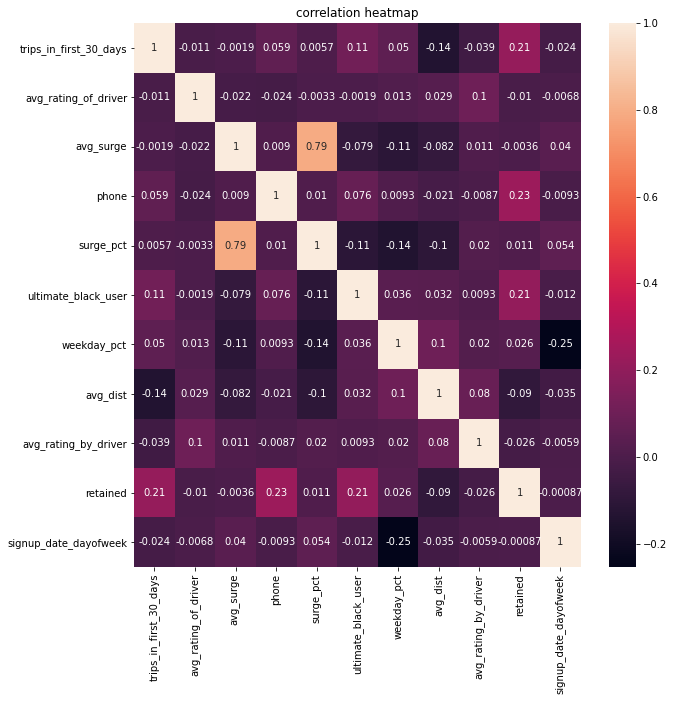

In [111]:
fig, ax = plt.subplots(figsize=(10,10))
ax = sns.heatmap(df.corr(),annot=True)
plt.title('correlation heatmap')
plt.show()

## some features show some linear correlation to target, avg_surge and surg_pct are highlt correlated  

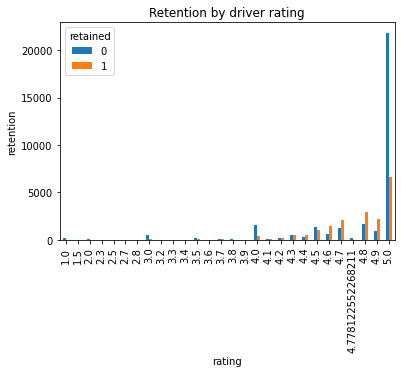

In [22]:
## try cross tab between retention and other feature to see how it splits the data

pd.crosstab(df.avg_rating_by_driver,df.retained).plot(kind='bar')
plt.title('Retention by driver rating')
plt.xlabel('rating')
plt.ylabel('retention')
plt.savefig('retention by rating by driver')

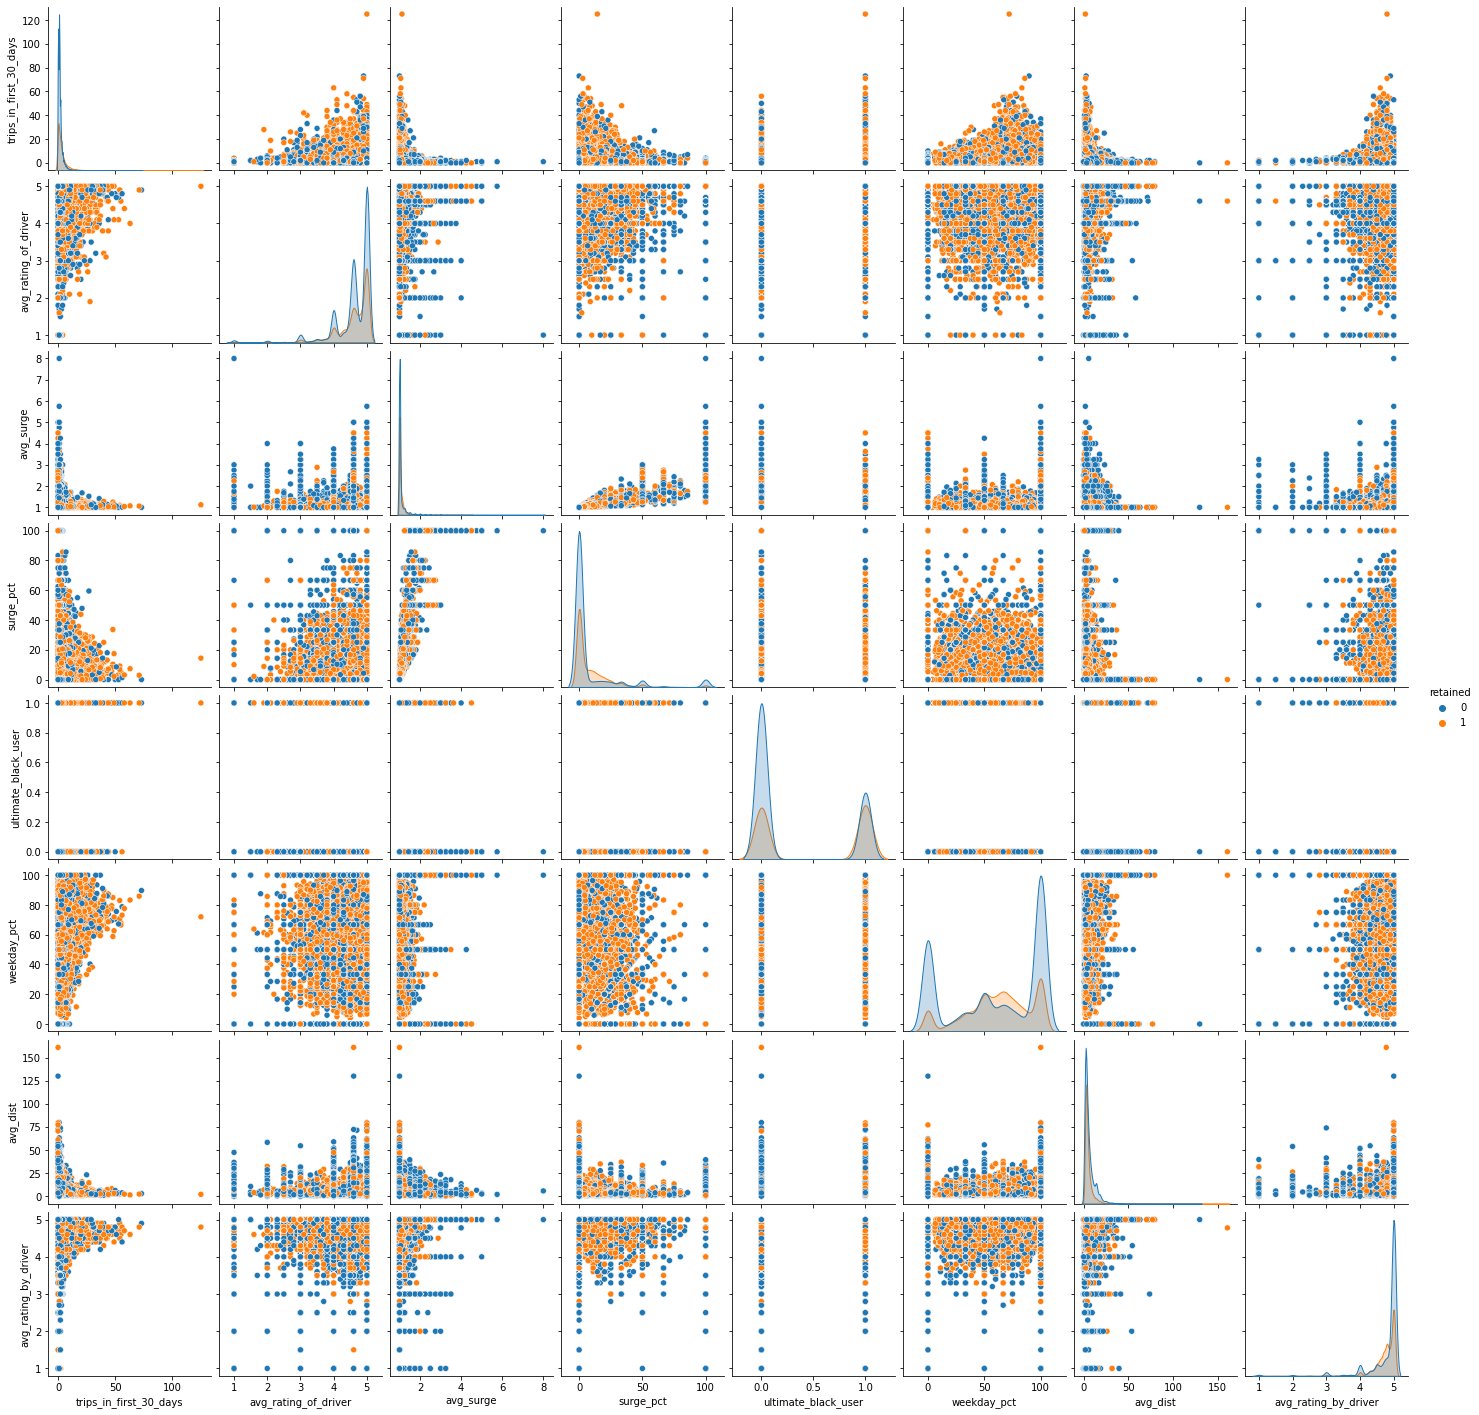

In [139]:
sns.pairplot(df,hue='retained')
# g = sns.PairGrid(df,hue='retained')

# # g.map_upper(sns.kdeplot, shade =True)
# # g.map_lower(plt.scatter, alpha = 0.6)

In [114]:
df.columns.values



array(['trips_in_first_30_days', 'signup_date', 'avg_rating_of_driver',
       'avg_surge', 'last_trip_date', 'phone', 'surge_pct',
       'ultimate_black_user', 'weekday_pct', 'avg_dist',
       'avg_rating_by_driver', 'retained', 'signup_date_dayofweek',
       'city2', 'city3'], dtype=object)

### One hot encode the city category 

In [112]:

# creating instance of one-hot-encoder
enc = OneHotEncoder(handle_unknown='error',drop='first')
# passing bridge-types-cat column (label encoded values of bridge_types)
enc_df = pd.DataFrame(enc.fit_transform(df[['city']]).toarray(),columns=['city2','city3'])

enc_df
# # merge with main df bridge_df on key values
df = df.join(enc_df)
df.drop('city',inplace=True,axis=1)
df.head()

,trips_in_first_30_days,signup_date,avg_rating_of_driver,avg_surge,last_trip_date,phone,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver,retained,signup_date_dayofweek,city2,city3
0,4,2014-01-25,4.7,1.10,2014-06-17,1,15.4,1,46.2,3.67,5.0,1,5,1.0,0.0
1,0,2014-01-29,5.0,1.00,2014-05-05,0,0.0,0,50.0,8.26,5.0,0,2,0.0,0.0
2,3,2014-01-06,4.3,1.00,2014-01-07,1,0.0,0,100.0,0.77,5.0,0,0,0.0,0.0
3,9,2014-01-10,4.6,1.14,2014-06-29,1,20.0,1,80.0,2.36,4.9,1,4,1.0,0.0
4,14,2014-01-27,4.4,1.19,2014-03-15,0,11.8,0,82.4,3.13,4.9,0,0,0.0,1.0


In [116]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
trips_in_first_30_days,49992.0,2.278405,3.792953,0.0,0.00,1.00,3.00,125.00
avg_rating_of_driver,49992.0,4.601512,0.565008,1.0,4.50,4.70,5.00,5.00
avg_surge,49992.0,1.074776,0.222352,1.0,1.00,1.00,1.05,8.00
phone,49992.0,0.699592,0.458440,0.0,0.00,1.00,1.00,1.00
surge_pct,49992.0,8.850952,19.960094,0.0,0.00,0.00,8.60,100.00
ultimate_black_user,49992.0,0.377080,0.484660,0.0,0.00,0.00,1.00,1.00
weekday_pct,49992.0,60.929833,37.078229,0.0,33.30,66.70,100.00,100.00
avg_dist,49992.0,5.797260,5.707610,0.0,2.42,3.88,6.94,160.96
avg_rating_by_driver,49992.0,4.778123,0.445780,1.0,4.70,5.00,5.00,5.00
retained,49992.0,0.366259,0.481786,0.0,0.00,0.00,1.00,1.00


In [118]:
df = df.dropna()
df.shape

(49984, 15)

In [143]:
 X_train, X_test, y_train, y_test = train_test_split(  df.drop(columns=['last_trip_date','signup_date','retained']),df['retained'] , test_size=0.2, random_state=42)
    
    

In [144]:
 X_train.dtypes

trips_in_first_30_days      int64
avg_rating_of_driver      float64
avg_surge                 float64
phone                       int64
surge_pct                 float64
ultimate_black_user         int64
weekday_pct               float64
avg_dist                  float64
avg_rating_by_driver      float64
signup_date_dayofweek       int64
city2                     float64
city3                     float64
dtype: object

In [145]:

rf=RandomForestClassifier(max_depth = 5, bootstrap=True,n_estimators=100, random_state = 42)
rf.fit(X_train, y_train)

RandomForestClassifier(max_depth=5, random_state=42)

In [146]:
y_train_preds = rf.predict_proba(X_train)[:,1]
y_test_preds = rf.predict_proba(X_test)[:,1]

In [123]:

def calc_specificity(y_actual, y_pred, thresh):
 # calculates specificity
 return sum((y_pred < thresh) & (y_actual == 0)) /sum(y_actual ==0)
def print_report(y_actual, y_pred, thresh):
 
 auc = roc_auc_score(y_actual, y_pred)
 accuracy = accuracy_score(y_actual, (y_pred > thresh))
 recall = recall_score(y_actual, (y_pred > thresh))
 precision = precision_score(y_actual, (y_pred > thresh))
 specificity = calc_specificity(y_actual, y_pred, thresh)
 print('AUC:%.3f'%auc)
 print('accuracy:%.3f'%accuracy)
 print('recall:%.3f'%recall)
 print('precision:%.3f'%precision)
 print('specificity:%.3f'%specificity)
 print('prevalence:%.3f'%calc_prevalence(y_actual))
 print(' ' )
#  return auc, accuracy, recall, precision, specificity

In [43]:
print_report(y_train,y_train_preds,thresh=.36)
print('Validation')
print_report(y_test,y_test_preds,thresh=.36)

AUC:0.811
accuracy:0.742
recall:0.684
precision:0.636
specificity:0.775
prevalence:0.366
 
Validation
AUC:0.812
accuracy:0.744
recall:0.695
precision:0.640
specificity:0.772
prevalence:0.369
 


In [134]:
print(confusion_matrix(y_test,y_preds))

ff

[[5645  665]
 [1797 1890]]


In [131]:
y_preds=rf.predict(X_test)
print(classification_report(y_test,y_preds))


              precision    recall  f1-score   support

           0       0.76      0.89      0.82      6310
           1       0.74      0.51      0.61      3687

    accuracy                           0.75      9997
   macro avg       0.75      0.70      0.71      9997
weighted avg       0.75      0.75      0.74      9997



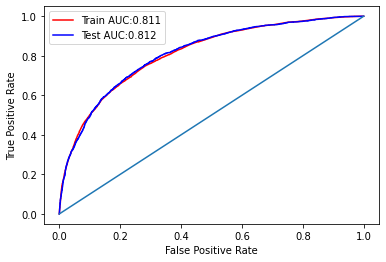

In [126]:

fpr_train, tpr_train, thresholds_train = roc_curve(y_train, y_train_preds)
auc_train = roc_auc_score(y_train, y_train_preds)
fpr_valid, tpr_valid, thresholds_valid = roc_curve(y_test, y_test_preds)
auc_valid = roc_auc_score(y_test, y_test_preds)
plt.plot(fpr_train, tpr_train, 'r-',label ='Train AUC:%.3f'%auc_train)
plt.plot(fpr_valid, tpr_valid, 'b-',label ='Test AUC:%.3f'%auc_valid)
plt.plot([0,1],[0,1])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()

### Training and testing AUC being idential points towards high bias and more features being required to create a more descriptive model

## Try grid search cross validation to see if hyperparameter turing improve model performance. 

In [162]:
grid = { 
    'n_estimators': [25,50,100,150],
    'max_features': ['sqrt', 'log2'],
    'max_depth' : [4,5,6,7],
    'criterion' :['gini', 'entropy'],
    'random_state' : [18],
    'bootstrap': [True, False]
}

In [163]:
rf_cv = GridSearchCV(estimator=RandomForestClassifier(), param_grid=grid, cv= 5)
rf_cv.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=RandomForestClassifier(),
             param_grid={'bootstrap': [True, False],
                         'criterion': ['gini', 'entropy'],
                         'max_depth': [4, 5, 6, 7],
                         'max_features': ['sqrt', 'log2'],
                         'n_estimators': [25, 50, 100, 150],
                         'random_state': [18]})

In [164]:
rf_cv.best_params_

{'bootstrap': False,
 'criterion': 'gini',
 'max_depth': 7,
 'max_features': 'sqrt',
 'n_estimators': 50,
 'random_state': 18}

In [165]:
y_pred = rf_cv.predict(X_test)
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.77      0.89      0.82      6310
           1       0.74      0.54      0.62      3687

    accuracy                           0.76      9997
   macro avg       0.75      0.71      0.72      9997
weighted avg       0.75      0.76      0.75      9997



In [166]:
print(confusion_matrix(y_test,y_pred))

[[5596  714]
 [1706 1981]]


In [167]:
y_train_preds = rf_cv.predict_proba(X_train)[:,1]
y_test_preds = rf_cv.predict_proba(X_test)[:,1]

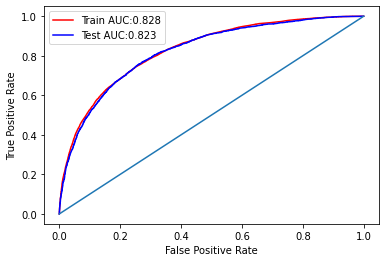

In [169]:

fpr_train, tpr_train, thresholds_train = roc_curve(y_train, y_train_preds)
auc_train = roc_auc_score(y_train, y_train_preds)
fpr_valid, tpr_valid, thresholds_valid = roc_curve(y_test, y_test_preds)
auc_valid = roc_auc_score(y_test, y_test_preds)
plt.plot(fpr_train, tpr_train, 'r-',label ='Train AUC:%.3f'%auc_train)
plt.plot(fpr_valid, tpr_valid, 'b-',label ='Test AUC:%.3f'%auc_valid)
plt.plot([0,1],[0,1])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()

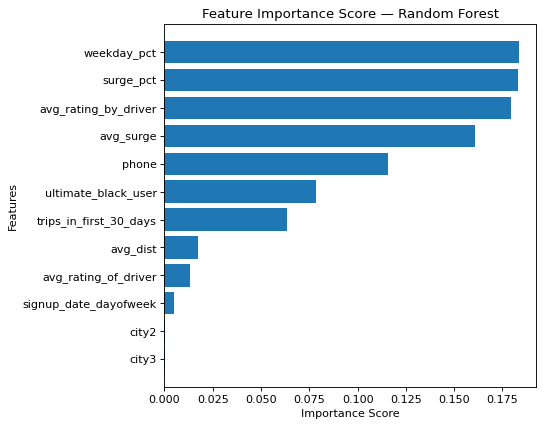

In [170]:
feature_importances = pd.DataFrame(rf_cv.best_estimator_.feature_importances_,
 index = X_train.columns,
 columns=['importance']).sort_values('importance',
 ascending=False)
num = min([50,len(X_train.columns)])
ylocs = np.arange(num)
# get the feature importance for top num and sort in reverse order
values_to_plot = feature_importances.iloc[:num].values.ravel()[::-1]
feature_labels = list(feature_importances.iloc[:num].index)[::-1]
plt.figure(num=None, figsize=(6, 6), dpi=80, facecolor='w', edgecolor='k');
plt.barh(ylocs, values_to_plot, align = 'center')
plt.ylabel('Features')
plt.xlabel('Importance Score')
plt.title('Feature Importance Score — Random Forest')
plt.yticks(ylocs, feature_labels)
plt.show()



## Insight

- city columns dont have any inportance to model and can be removed 

- clearly avg rating by the driver of rider reflects on if someone will continue to use the service, the could be do survivor bias and people being removed from the service are then deemed at churn as they can no longer use the service.

## Cannot use days since last as this is an aggregate of retained which is generated from the same last trip date feature

In [ ]:
# df['last_trip_date'] = pd.to_datetime(df['last_trip_date'],format='%Y-%m-%d')

# df['days_since_last'] = df['last_trip_date'].max() - df['last_trip_date']
# df['days_since_last'] = df['days_since_last'].dt.days